In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia

In [2]:
# Getting metadata for the FGKM sample of stars.
fgkm_table = Gaia.load_table('gaiadr3.gold_sample_fgkm_stars')
print(fgkm_table)

Retrieving table 'gaiadr3.gold_sample_fgkm_stars'
TAP Table name: gaiadr3.gaiadr3.gold_sample_fgkm_stars
Description: Stellar astrophysical parameters of the golden sample of F, G, K, and M stars from \cite{DR3-DPACP-123}.  Values are identical to the ones in the \texttt{astrophysical\_parameters} and \texttt{astrophysical\_parameters\_supp} tables, but only those values retained after filtering are copied over.
Num. columns: 21


In [3]:
# Looking at which data columns are available to use in this sample.
for column in fgkm_table.columns:
    print(column.name)

source_id
teff_gspphot
logg_gspphot
mh_gspphot
ag_gspphot
ebpminrp_gspphot
alphafe_gspspec
teff_gspspec
logg_gspspec
mh_gspspec
radius_flame
lum_flame
mass_flame
age_flame
evolstage_flame
radius_flame_spec
lum_flame_spec
mass_flame_spec
age_flame_spec
evolstage_flame_spec
spectraltype_esphs


In [4]:
# Asynchronous query with Gaia to get the data needed. Takes a while to fully run.
job = Gaia.launch_job_async("SELECT source_id, lum_flame, teff_gspphot, mh_gspphot, age_flame, ebpminrp_gspphot \
FROM gaiadr3.gold_sample_fgkm_stars")

INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
# Setting for fgkm and checking to make sure we have the data we want.
fgkm = job.get_results()
print(fgkm)

     source_id      lum_flame  teff_gspphot ... age_flame ebpminrp_gspphot
                      solLum        K       ...    Gyr          mag       
------------------- ---------- ------------ ... --------- ----------------
6861285438765002752  0.6155775     5235.629 ...        --           0.0117
6863235079039379072  1.8791959    5737.0728 ... 10.420385           0.0315
5902858332727663744   0.739251    5271.8486 ...        --           0.0827
5908354894417447552  3.7059128    5772.1455 ...   6.13364            0.039
5907629629058853888   1.496285    5911.4395 ... 6.3011494           0.1986
5828820312088611968  0.7304129     5338.921 ...        --           0.0613
5828837693799144960  4.8808928    6848.3745 ... 1.4717058           0.0768
4038116191436125568    2.11209    5279.1123 ... 12.221438            0.027
6726328048697008384   2.828305    6386.1514 ... 2.5267782            0.078
5431031814185145984  3.7884624    6548.1406 ... 2.2278419           0.0226
                ...      

In [6]:
# Setting up the data columns for use. 
lum = fgkm['lum_flame']
Teff = fgkm['teff_gspphot']
logL = np.log10(lum)
FeH = fgkm['mh_gspphot']
age = fgkm['age_flame']
red = fgkm['ebpminrp_gspphot']

In [7]:
# Using AstroML binned statistics to set up color coding for N.
from astroML.stats import binned_statistic_2d
N, xedges, yedges = binned_statistic_2d(Teff, logL, FeH,
                                        'count', bins=100)

In [8]:
# Color coding for FeH. Gives an error but still works in the plots.
FeH_mean, xedges, yedges = binned_statistic_2d(Teff, logL, FeH,
                                               'mean', bins=100)

C:\Users\Brandon\anaconda3\lib\site-packages\astroML\stats\_binned_statistic.py:321: RuntimeWarning: invalid value encountered in true_divide
  result[a] /= flatcount


In [9]:
# Color coding for reddening.
red_mean, xedges, yedges = binned_statistic_2d(Teff, logL, red,
                                               'mean', bins=100)

In [10]:
# Color coding for age. I attempted a few different ways of doing this, including taking the mean, but I always get either 
# the plot result below or an error message about mismatched counts or mismatched dimensions. I attempt to look further into 
# the problem after the plots.
#-----------------------------------
age, xedges, yedges = binned_statistic_2d(Teff, logL, age,
                                               bins=100)

In [11]:
# Choosing different color maps for the plots.
cmap = plt.get_cmap('afmhot')
cmap2 = plt.get_cmap('gist_rainbow')
cmap3 = plt.get_cmap('Reds')
cmap4 = plt.get_cmap('rainbow')

C:\Users\Brandon\AppData\Local\Temp/ipykernel_8840/3446331186.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(N.T), origin='lower',


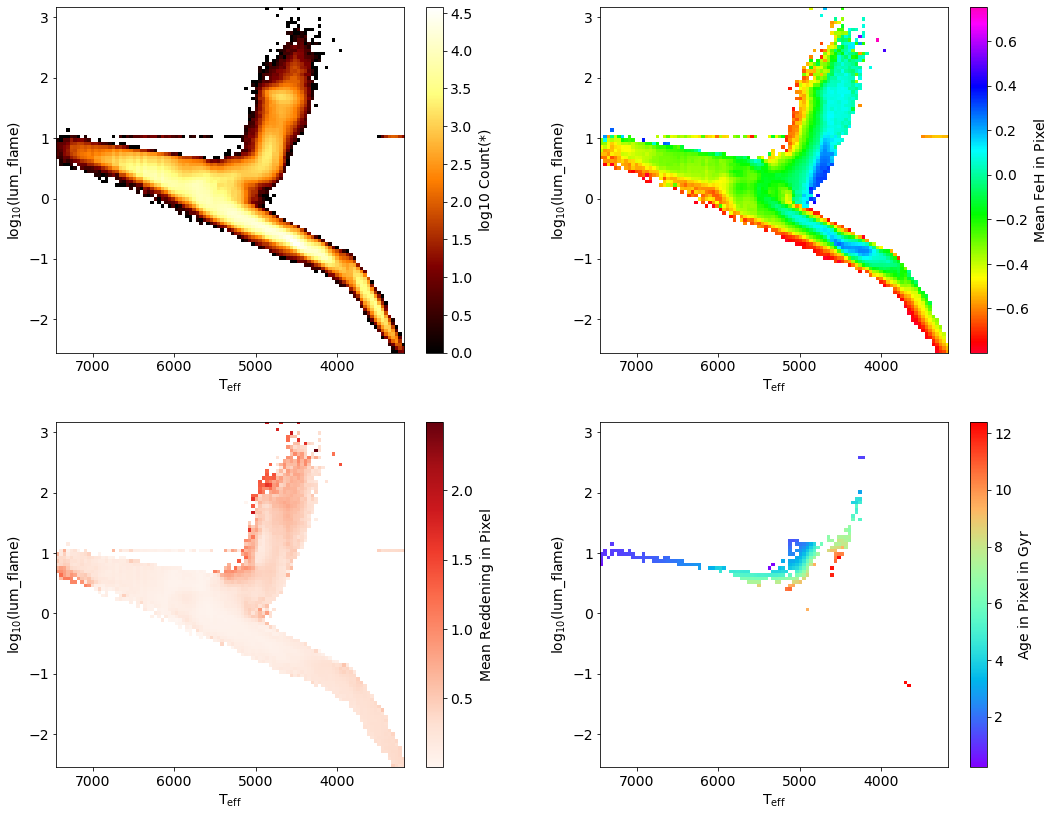

In [12]:
# Setting up plots for Figure 9, Panel 4 recreation.
fig = plt.figure(figsize=(16, 12))
fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95,
                    bottom=0.07, top=0.95)

plt.rcParams['font.size'] = 14


#------------------------------------------------------------
# Create first plot color coded by N. Gives an error, but the plot still works and looks like what we want.
plt.subplot(221)
plt.plot(logL, Teff)
plt.imshow(np.log10(N.T), origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap)

plt.xlim(xedges[-1], xedges[0])
plt.ylim(yedges[0], yedges[-1])
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{log_{10}(lum\_flame)}$')

cb = plt.colorbar(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0, 4.5],
                  orientation='vertical')
cb.set_label(r'$\mathrm{log10\ Count(*)}$')


#------------------------------------------------------------
# Create second plot color coded by FeH.
plt.subplot(222)
plt.plot(logL, Teff)
plt.imshow(FeH_mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap2)

plt.xlim(xedges[-1], xedges[0])
plt.ylim(yedges[0], yedges[-1])
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{log_{10}(lum\_flame)}$')

cb = plt.colorbar(ticks=[-.8, -.6, -.4, -.2, 0, .2, .4, .6, .8],
                  format=r'$%.1f$', orientation='vertical')
cb.set_label(r'$\mathrm{Mean\ FeH\ in\ Pixel}$')


#------------------------------------------------------------
# Create third plot color coded by reddening.
plt.subplot(223)
plt.plot(logL, Teff)
plt.imshow(red_mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap3)

plt.xlim(xedges[-1], xedges[0])
plt.ylim(yedges[0], yedges[-1])
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{log_{10}(lum\_flame)}$')

cb = plt.colorbar(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5],
                  format=r'$%.1f$', orientation='vertical')
cb.set_label(r'$\mathrm{Mean\ Reddening\ in\ Pixel}$')


#------------------------------------------------------------
# Create fourth plot color coded by age.
plt.subplot(224)
plt.plot(logL, Teff)
plt.imshow(age.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap4)

plt.xlim(xedges[-1], xedges[0])
plt.ylim(yedges[0], yedges[-1])
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{log_{10}(lum\_flame)}$')

cb = plt.colorbar(ticks=[0, 2, 4, 6, 8, 10, 12, 14],
                  orientation='vertical')
cb.set_label(r'$\mathrm{Age\ in\ Pixel\ in\ Gyr}$')

In [13]:
# Checking the age_flame column to see if there are a large number of NaN values to explain the whitespace on the fourth plot. 
# It appears that there are and it may explain the problem.
age_check = age[:1000]
print(age_check)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [14]:
# Count of how many rows have NaN values, but it is not enough to fully explain the whitespace. The age_flame column may 
# be using the symbol -- to indicate missing values, but attempts to look at this have been giving errors.
np.count_nonzero(np.isnan(age))

9763

In [15]:
# Crossmatching the source id's of the FGKM gold sample with Gaia DR3 to obtain their RA and DEC values for second set of 
# plots. This query also takes a while to fully run.
job2 = Gaia.launch_job_async("SELECT source_id, ra, dec \
FROM gaiadr3.gaia_source AS dr3 \
JOIN gaiadr3.gold_sample_fgkm_stars AS xmatch USING (source_id)")

INFO: Query finished. [astroquery.utils.tap.core]


In [16]:
# Setting fgkm2 and checking the results of second query for RA and DEC.
fgkm2 = job2.get_results()
print(fgkm2)

     source_id              ra                 dec        
                           deg                 deg        
------------------- ------------------ -------------------
      8044474553216  44.92766579120339 0.21912825046951404
     12545600306304 45.234476460376314  0.3181518585465403
     14401026146688 45.047857726713275  0.2950742549763921
     15637976759168 45.194622238199536 0.34414946992382933
     16531329957376  45.14136310917188   0.359598094469785
     16733192740608 45.152965337754885  0.3863421150872851
     26834955821312 45.010276577015645  0.3511012847339119
     30034707100800 45.001654463074004 0.44755122107778456
     38349763812096  45.48838733576979 0.45409178479524165
     38693361197568  45.40784599738709  0.4530893589745901
                ...                ...                 ...
6347928441918018432 312.17015782837916  -83.14579789742785
6347929197832256000  312.6251294873717   -83.0622966466475
6347930434782730240  314.7309568760263  -83.334881330477

In [17]:
# Setting RA and DEC variables.
ra = fgkm2['ra']
dec = fgkm2['dec']

Text(0.5, 1.1, 'Gold Sample FGKM Locations')

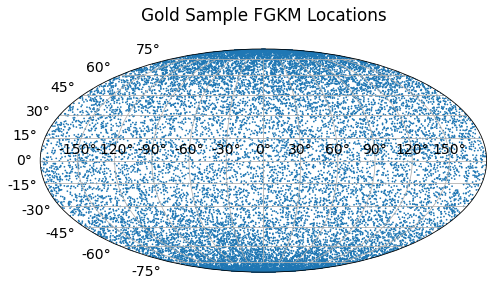

In [67]:
# Plot for counts on the sky.
#---------------------------------------------
plt.figure(figsize=(8,8))
ax = plt.axes(projection='mollweide')
plt.scatter(ra, dec, s=3,
            edgecolors='none', linewidths=0)
plt.grid(True)

plt.title('Gold Sample FGKM Locations', x=0.5, y=1.1)


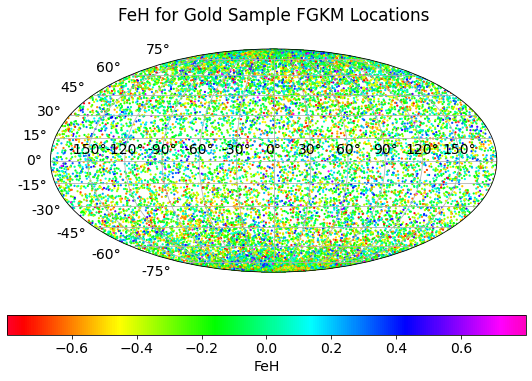

In [64]:
# Counts on the sky color coded by Feh, had to be given a seperate cell to make the color bar work.
#---------------------------------------------
plt.figure(figsize=(8,8))
ax = plt.axes(projection='mollweide')
plt.scatter(ra, dec, s=5, c=FeH, cmap=cmap2, 
            edgecolors='none', linewidths=0)
plt.grid(True)

plt.title('FeH for Gold Sample FGKM Locations', x=0.5, y=1.1)
cb = plt.colorbar(cax=plt.axes([0.05, 0.2, 0.9, 0.035]),
                  orientation='horizontal',
                  ticks=np.linspace(-0.6, 0.6, 7))
cb.set_label('FeH')

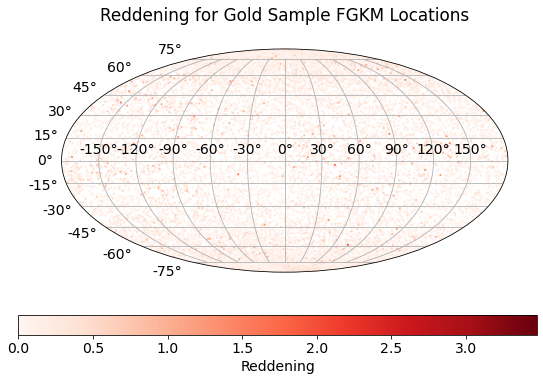

In [68]:
# Counts on sky color coded by reddening.
#---------------------------------------------
plt.figure(figsize=(8,8))
ax = plt.axes(projection='mollweide')
plt.scatter(ra, dec, s=5, c=red, cmap=cmap3, 
            edgecolors='none', linewidths=0)
plt.grid(True)

plt.title('Reddening for Gold Sample FGKM Locations', x=0.5, y=1.1)
cb = plt.colorbar(cax=plt.axes([0.05, 0.2, 0.9, 0.035]),
                  orientation='horizontal',
                  ticks=np.linspace(0, 3.5, 8))
cb.set_label('Reddening')

In [36]:
# Fourth plot color coded by age. I haven't been able to get this one to work and it may be a result of the missing values 
# that I mentioned above. I left the code below, but it should give an error about the c value not matching the count.
#--------------------------------------------
plt.figure(figsize=(8,8))
ax = plt.axes(projection='mollweide')
plt.scatter(ra, dec, s=5, c=age, cmap=cmap4, 
            edgecolors='none', linewidths=0)
plt.grid(True)

plt.title('Age of Gold Sample FGKM Locations', x=0.5, y=1.1)
cb = plt.colorbar(cax=plt.axes([0.05, 0.2, 0.9, 0.035]),
                  orientation='horizontal',
                  ticks=np.linspace(0, 14, 6))
cb.set_label('Age in Gyr')